# Laboratorio 9 - Data Science
## Integrantes:
### Mario Guerra - 21008
### Javier Alvarado - 21188

In [56]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import re
import string
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import unidecode
from textblob import TextBlob
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import ace_tools_open as tools
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from PIL import Image
from transformers import pipeline

In [27]:
# Descargar recursos de NLTK si no están disponibles
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mague\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mague\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Limpieza y Preprocesamiento de Datos

In [28]:
with open('tioberny.txt', 'r', encoding='utf-16') as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame(data)

In [29]:
# Convertir texto a minúsculas.
df['rawContent'] = df['rawContent'].str.lower()

# Quitar URLs.
df['rawContent'] = df['rawContent'].apply(lambda x: re.sub(r'http\S+', '', x))

# Eliminar signos de puntuación dejando solamente @ y #.
df['rawContent'] = df['rawContent'].apply(lambda x: re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ0-9@#\s]', '', x))

# Eliminar stopwords del conjunto de datos.
stop_words = set(stopwords.words('spanish'))

df['rawContent'] = df['rawContent'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [30]:
df = df.drop_duplicates(subset='id')
df['user_id'] = df['user'].apply(lambda x: x['id'])
df['username'] = df['user'].apply(lambda x: x['username'])
df['mentioned_users'] = df['mentionedUsers'].apply(lambda mentions: [user['username'] for user in mentions])
df['in_reply_to_user_id'] = df['inReplyToUser'].apply(lambda x: x['id'] if x else None)
df['retweeted_user_id'] = df['retweetedTweet'].apply(lambda x: x['user']['id'] if x else None)

In [31]:
# Estructura para las menciones.
mentions_df = df[['user_id', 'username', 'mentioned_users']].explode('mentioned_users')

# Renombrar las columnas para representarlas como aristas (usuario origen -> usuario destino)
mentions_df = mentions_df.rename(columns={'user_id': 'source_user', 'mentioned_users': 'target_user'})

# Estructura para las respuestas.
replies_df = df[['user_id', 'username', 'in_reply_to_user_id']].dropna()
# Renombrar las columnas para representarlas como aristas (usuario origen -> usuario destino)
replies_df = replies_df.rename(columns={'user_id': 'source_user', 'in_reply_to_user_id': 'target_user'})

# Estructura para los retweets.
retweets_df = df[['user_id', 'username', 'retweeted_user_id']].dropna()
# Renombrar las columnas para representarlas como aristas (usuario origen -> usuario destino)
retweets_df = retweets_df.rename(columns={'user_id': 'source_user', 'retweeted_user_id': 'target_user'})

In [32]:
# Concatenar todas las interacciones (menciones, respuestas y retweets).
edges_df = pd.concat([mentions_df, replies_df, retweets_df], ignore_index=True)

# Eliminar duplicados si es necesario.
edges_df = edges_df.drop_duplicates()

# Función para verificar si un valor es una cadena y no contiene solo números.
def is_valid_user(user):
    return isinstance(user, str) and not user.isdigit()

# Aplicar el filtro para eliminar interacciones no válidas.
edges_df = edges_df[edges_df['username'].apply(is_valid_user) & edges_df['target_user'].apply(is_valid_user)]

# Visualización de gráficos interactivos

In [38]:
# Extraer menciones de usuarios con @ en el contenido de los tweets
df['mentions'] = df['rawContent'].apply(lambda x: re.findall(r'@\w+', x))

# Contar las menciones más frecuentes
all_mentions = df['mentions'].explode().value_counts()

# Seleccionar las 50 menciones más frecuentes
top_mentions = all_mentions.head(50).reset_index()
top_mentions.columns = ['mention', 'count']

# Crear la gráfica interactiva con Plotly
fig = px.bar(top_mentions, x='mention', y='count', 
             title='Top 50 Menciones en Tweets',
             labels={'mention': 'Mención de Usuario', 'count': 'Cantidad'},
             color_discrete_sequence=['skyblue'])

# Mostrar la gráfica
fig.show()

In [36]:
# Unir todas las menciones en un solo string
mentions_string = ' '.join(all_mentions.index)

# Generar la nube de palabras con colores personalizados (turquesa, verde limón, morado)
def color_func(*args, **kwargs):
    colors = ['#40E0D0', '#BFFF00', '#800080']  # Turquesa, verde limón, morado
    return np.random.choice(colors)

wordcloud_mentions = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(mentions_string)

# Guardar la nube de palabras como imagen
wordcloud_mentions.to_file('wordcloud_mentions.png')

# Cargar la imagen de la nube de palabras y mostrarla con Plotly
img = Image.open('wordcloud_mentions.png')

fig = px.imshow(np.array(img))
fig.update_layout(
    title='Nube de Palabras de Menciones',
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    coloraxis_showscale=False,
    margin=dict(l=0, r=0, t=30, b=0)  # Ajustar márgenes
)
fig.show()


In [39]:
# Unir todos los hashtags en un solo string
hashtags_string = ' '.join(df['hashtags'].explode().dropna())

# Crear la nube de palabras
wordcloud_hashtags = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(hashtags_string)

# Guardar la nube de palabras como imagen
wordcloud_hashtags.to_file('wordcloud_hashtags.png')

# Cargar la imagen de la nube de palabras y mostrarla con Plotly
img = Image.open('wordcloud_hashtags.png')

fig = px.imshow(np.array(img))
fig.update_layout(
    title='Nube de Palabras de Hashtags',
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False),
    coloraxis_showscale=False,
    margin=dict(l=0, r=0, t=30, b=0)  # Ajustar márgenes
)
fig.show()

Número de nodos (filtrado): 1106
Número de aristas (filtrado): 7860


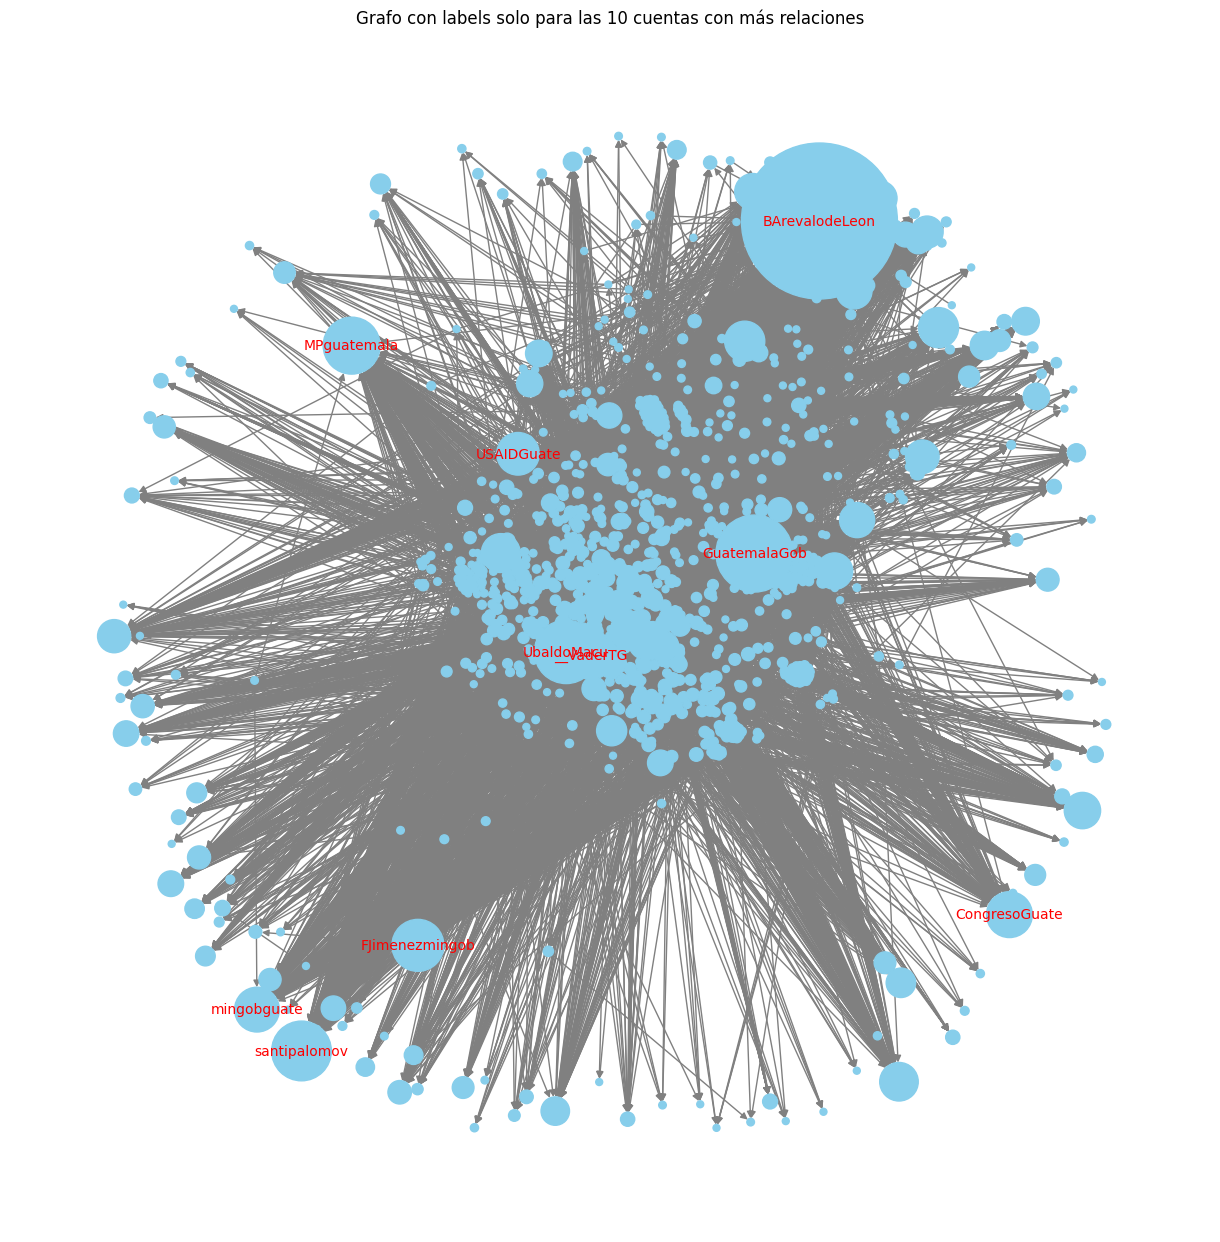

In [46]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir nodos y aristas desde el DataFrame
for index, row in edges_df.iterrows():
    G.add_edge(row['username'], row['target_user'])

# Contar la cantidad de interacciones para cada usuario (como source o target)
user_counts = pd.concat([edges_df['username'], edges_df['target_user']]).value_counts()

# Crear el grafo dirigido con nodos únicos
G = nx.DiGraph()

# Añadir nodos con el atributo 'size' basado en el número de interacciones
for user, count in user_counts.items():
    G.add_node(user, size=count)

# Añadir las aristas (interacciones entre los usuarios)
for index, row in edges_df.iterrows():
    G.add_edge(row['username'], row['target_user'])

labels = {user: user for user in G.nodes()}

# Extraer el tamaño de los nodos basado en el número de interacciones
node_sizes = [G.nodes[user]['size'] * 5 for user in G.nodes()]  # Multiplicamos para hacerlos más visibles

# Crear el primer filtro para eliminar nodos con menos de 5 relaciones
user_counts_filtered = user_counts[user_counts >= 5]  # Solo usuarios con 5 o más relaciones

# Crear un nuevo grafo dirigido con nodos filtrados
G_filtered = nx.DiGraph()

# Añadir nodos con el atributo 'size' solo para usuarios que tienen 5 o más relaciones
for user, count in user_counts_filtered.items():
    G_filtered.add_node(user, size=count)

# Añadir las aristas para las interacciones solo si ambos usuarios están en el conjunto filtrado
for index, row in edges_df.iterrows():
    if row['username'] in G_filtered and row['target_user'] in G_filtered:
        G_filtered.add_edge(row['username'], row['target_user'])

# Verificar la cantidad de nodos y aristas
print(f"Número de nodos (filtrado): {G_filtered.number_of_nodes()}")
print(f"Número de aristas (filtrado): {G_filtered.number_of_edges()}")

labels = {user: user for user in G_filtered.nodes()}

# Extraer los tamaños de los nodos
node_sizes_filtered = [G_filtered.nodes[user]['size'] * 5 for user in G_filtered.nodes()]

# Crear el primer filtro para eliminar nodos con menos de 5 relaciones
user_counts_filtered = user_counts[user_counts >= 5]  # Solo usuarios con 5 o más relaciones

# Crear un nuevo grafo dirigido con nodos filtrados
G_filtered = nx.DiGraph()

# Añadir nodos con el atributo 'size' solo para usuarios que tienen 5 o más relaciones
for user, count in user_counts_filtered.items():
    G_filtered.add_node(user, size=count)

# Añadir las aristas para las interacciones solo si ambos usuarios están en el conjunto filtrado
for index, row in edges_df.iterrows():
    if row['username'] in G_filtered and row['target_user'] in G_filtered:
        G_filtered.add_edge(row['username'], row['target_user'])

labels = {user: user for user in G_filtered.nodes()}

# Extraer los tamaños de los nodos
node_sizes_filtered = [G_filtered.nodes[user]['size'] * 5 for user in G_filtered.nodes()]

pos_filtered = nx.spring_layout(G_filtered, k=0.15)

# Obtener los 10 usuarios con más relaciones
top_10_users = user_counts_filtered.nlargest(10).index

# Dibujar el grafo con labels solo para los top 10
plt.figure(figsize=(12, 12))
nx.draw(G_filtered, pos_filtered, with_labels=False, node_size=node_sizes_filtered, node_color='skyblue', font_size=10, edge_color='black')

# Añadir labels solo para los top 10
top_labels = {user: user for user in top_10_users}
nx.draw_networkx_labels(G_filtered, pos_filtered, labels=top_labels, font_size=10, font_color='black')

plt.title('Grafo con labels solo para las 10 cuentas con más relaciones')
plt.show()


In [53]:
# Convertir el grafo dirigido a no dirigido para Louvain
G_undirected = G.to_undirected()

# Aplicar el algoritmo de Louvain para detectar comunidades
partition = community_louvain.best_partition(G_undirected)

# Añadir la comunidad detectada como un atributo de los nodos
for node, community_id in partition.items():
    G.nodes[node]['community'] = community_id

# Calcular centralidades
degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Obtener los top 10 usuarios por centralidad de grado e intermediación
top_10_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Crear DataFrames para graficar
top_10_degree_df = pd.DataFrame(top_10_degree, columns=['Usuario', 'Centralidad de Grado'])
top_10_betweenness_df = pd.DataFrame(top_10_betweenness, columns=['Usuario', 'Centralidad de Intermediación'])

# Crear gráficos de barras interactivos en Plotly
fig_degree = px.bar(top_10_degree_df, x='Usuario', y='Centralidad de Grado', 
                    title="Top 10 Usuarios por Centralidad de Grado",
                    labels={'Usuario': 'Usuario', 'Centralidad de Grado': 'Centralidad de Grado'},
                    color='Centralidad de Grado', color_continuous_scale=['#BFFF00', '#40E0D0', '#800080'])

fig_betweenness = px.bar(top_10_betweenness_df, x='Usuario', y='Centralidad de Intermediación', 
                         title="Top 10 Usuarios por Centralidad de Intermediación",
                         labels={'Usuario': 'Usuario', 'Centralidad de Intermediación': 'Centralidad de Intermediación'},
                         color='Centralidad de Intermediación', color_continuous_scale=['#BFFF00', '#40E0D0', '#800080'])

# Añadir definición de centralidad de grado al gráfico
fig_degree.add_annotation(
    text="Mide cuántas conexiones directas tiene un nodo con otros nodos. \n"
         "In-degree representa menciones recibidas y Out-degree las menciones realizadas.",
    showarrow=False,
    xref="paper", yref="paper",
    x=0.5, y=1.15,
    font=dict(size=12),
    align="center",
    bgcolor="white",
    bordercolor="black",
    borderwidth=2
)

# Añadir definición de centralidad de intermediación al gráfico
fig_betweenness.add_annotation(
    text="Mide cuántas veces un nodo actúa como puente entre otros nodos.\n"
         "Es importante para identificar los nodos clave en la red.",
    showarrow=False,
    xref="paper", yref="paper",
    x=0.5, y=1.15,
    font=dict(size=12),
    align="center",
    bgcolor="white",
    bordercolor="black",
    borderwidth=2
)

# Hacer que ambos gráficos se vean consistentes
fig_degree.update_traces(marker=dict(line=dict(width=1.5, color='black')))
fig_betweenness.update_traces(marker=dict(line=dict(width=1.5, color='black')))

# Mostrar gráficos juntos
fig_degree.show()
fig_betweenness.show()

In [ ]:
# Inicializar el modelo de análisis de sentimiento multilingüe
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Aplicar el modelo a cada tweet
df['sentimiento_bert'] = df['rawContent'].apply(lambda tweet: sentiment_analyzer(tweet)[0]['label'])

# Contar cuántos tweets caen en cada categoría de sentimiento
sentiment_counts_bert = df['sentimiento_bert'].value_counts()
print("Distribución del sentimiento en los tweets con BERT:")
print(sentiment_counts_bert)

# Mostrar algunos ejemplos de tweets por sentimiento
print("\nEjemplos de tweets positivos:")
print(df[df['sentimiento_bert'] == '5 stars'].head(3))

print("\nEjemplos de tweets negativos:")
print(df[df['sentimiento_bert'] == '1 star'].head(3))

# Contar cuántos tweets caen en cada categoría de sentimiento
sentiment_counts_bert = df['sentimiento_bert'].value_counts()

# Crear un gráfico de barras para visualizar la distribución del sentimiento
sentiment_counts_bert.plot(kind='bar', color=['red', 'green', 'orange', 'yellow', 'grey'], figsize=(8, 6))
plt.title('Distribución del Sentimiento (Modelo BERT)')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Tweets')
plt.xticks(rotation=0)
plt.show()

# Dashboard

In [ ]:
# Código aquí